In [135]:
import sim
%pylab inline
plt.style.use('seaborn-whitegrid')
pylab.rcParams['figure.figsize'] = (10.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [136]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  49650
Omnirob is at [x,y,z]= [7.62499475479126, 8.546045303344727, 0.3544987440109253]
Disconnected


# Robot

In [137]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

# Plot

In [138]:
def point_to_point_traj(x1, x2, v1, v2, delta_t):
  t = np.linspace(0, delta_t, 100) 
  ti = t[1]-t[0]
  a0 = x1
  a1 = v1
  a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
  a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

  polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
  derivative = a1 + 2*a2 * t + 3 * a3 * t**2
  return polynomial, derivative, ti


def piecewise3D (X,Y,Z,Vx,Vy,Vz,T):
    theta_x, theta_y, theta_z, dx, dy, dz, time_steps = [], [], [], [], [], [], []

    for i in range(len(P)-1):          
        theta_xi, dxi, ti = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        theta_yi, dyi, ti = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])
        theta_zi, dzi, ti = point_to_point_traj(Z[i], Z[i+1], Vz[i], Vz[i+1], T[i+1] - T[i])
        
        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        theta_z += theta_zi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()
        dz += dzi.tolist()
        for j in range(100):
            time_steps.append(ti)
        

        ax.plot(theta_xi, theta_yi, theta_zi)
    return theta_x, theta_y, theta_z, dx, dy, dz, time_steps

In [139]:
# Plotting
def plot_points():
    ax.plot(X,Y,Z,ls='--')
    ax.scatter(X,Y,Z,c='darkorange')
    ax.quiver(X,Y,Z, Vx, Vy, Vz, color='r')
    
# Speed
def plot_speed():
    speed = np.sqrt(np.array(dx)**2 + np.array(dy)**2)
    plot(speed)

In [140]:
##### Requirements for the trajectory

r = robot(frame_name='Quadricopter_target')  # Create an instance of our robot

# Waypoints
p1 = r.get_position()
p2 = r.get_object_position('Sphere5')
p3 = r.get_object_position('Sphere6')
p4 = r.get_object_position('Sphere7')
p5 = r.get_object_position('Sphere10')
p6 = r.get_object_position('Sphere8')
p61 = [-1.65,-7.075,2.5]
p7 = r.get_object_position('Sphere9')

# Velocities
v1 = [0.0001,0,0]
v2 = [0,-2,0]
v3 = [0,2,0]
v4 = [2,-1,0]
v5 = [0,-2,2]
v6 = [-2,0,0]
v61 = [-2,0,0]
v7 = [0.0001,0,0]


# Time
t1 = 0
t2 = t1 + 8
t3 = t2 + 5
t4 = t3 + 4
t5 = t4 + 2
t6 = t5 + 3
t61 = t6 + 2
t7 = t61 + 3
r.close_connection()

Robot connected
Connection closed


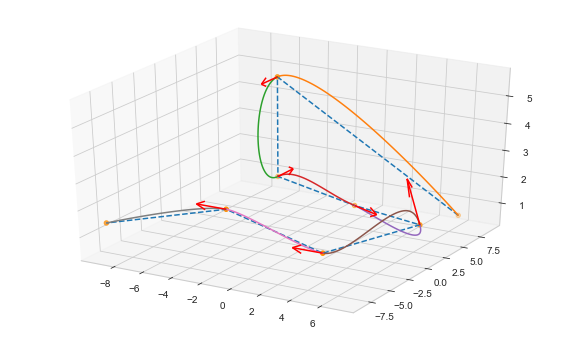

In [141]:
# Convert the initial conditions to a vector form
P = np.vstack((p1, p2, p3, p4, p5, p6, p61, p7))
V = np.vstack((v1, v2, v3, v4, v5, v6, v61, v7))
T = [t1, t2, t3, t4, t5, t6, t61, t7]

X, Y, Z = P[:,0], P[:,1], P[:,2]
Vx, Vy, Vz = V[:,0], V[:,1], V[:,2]

ax = axes(projection='3d')
plot_points()

# Piecewise function
theta_x, theta_y, theta_z, dx, dy, dz, time_steps = piecewise3D(X,Y,Z, Vx, Vy, Vz, T)

# Trajectory follower

In [143]:
r = robot(frame_name='Quadricopter_target')

# Connect to the sphere that will be a reference
ref_point = robot('Sphere11', client_id=r.client_id)

# Initial locations
robot_position = r.get_position()
print('Robot position: (%.2f, %.2f) '%(robot_position[0], robot_position[1]))

for xi, yi, zi, ti in zip(theta_x, theta_y, theta_z, time_steps):
    r.set_position([xi, yi, zi])
    time.sleep(ti)

r.close_connection()  # End

Robot connected
Robot connected
Robot position: (5.87, 9.05) 
Connection closed
